If you haven't gone through [Carl's Tutorial](https://github.com/carlshan/intro_to_machine_learning/blob/master/lessons/Reinforcement_Learning/RL_Tutorial.md), you may want to go through that and implement the hill-climbing policy before attempting this tutorial. I would not recommend implementing the policy gradient strategy unless you're interested in learning more about lower-level tensorflow. This tutorial uses the keras, like the others this semester.

Original code taken from [https://gist.github.com/EderSantana/c7222daa328f0e885093](https://gist.github.com/EderSantana/c7222daa328f0e885093)

In [2]:
%matplotlib inline
import json
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import sgd
import matplotlib.pyplot as plt

In [3]:
class Catch(object):
    def __init__(self, grid_size=10):
        self.grid_size = grid_size
        self.reset()

    def _update_state(self, action):
        """
        Input: action and states
        Ouput: new states and reward
        """
        state = self.state
        if action == 0:  # left
            action = -1
        elif action == 1:  # stay
            action = 0
        else:
            action = 1  # right
        f0, f1, basket = state[0]
        new_basket = min(max(1, basket + action), self.grid_size-1)
        f0 += 1
        out = np.asarray([f0, f1, new_basket])
        out = out[np.newaxis]

        assert len(out.shape) == 2
        self.state = out

    def _draw_state(self):
        im_size = (self.grid_size,)*2
        state = self.state[0]
        canvas = np.zeros(im_size)
        canvas[state[0], state[1]] = 1  # draw fruit
        canvas[-1, state[2]-1:state[2] + 2] = 1  # draw basket
        return canvas

    def _get_reward(self):
        fruit_row, fruit_col, basket = self.state[0]
        if fruit_row == self.grid_size-1:
            if abs(fruit_col - basket) <= 1:
                return 1
            else:
                return -1
        else:
            return 0

    def _is_over(self):
        if self.state[0, 0] == self.grid_size-1:
            return True
        else:
            return False

    def observe(self):
        canvas = self._draw_state()
        return canvas.reshape((1, -1))

    def act(self, action):
        self._update_state(action)
        reward = self._get_reward()
        game_over = self._is_over()
        return self.observe(), reward, game_over

    def reset(self):
        n = np.random.randint(0, self.grid_size-1, size=1)
        m = np.random.randint(1, self.grid_size-2, size=1)
        self.state = np.asarray([0, n, m])[np.newaxis]


class ExperienceReplay(object):
    def __init__(self, max_memory=100, discount=.9):
        self.max_memory = max_memory
        self.memory = list()
        self.discount = discount

    def remember(self, states, game_over):
        # memory[i] = [[state_t, action_t, reward_t, state_t+1], game_over?]
        self.memory.append([states, game_over])
        if len(self.memory) > self.max_memory:
            del self.memory[0]

    def get_batch(self, model, batch_size=10):
        len_memory = len(self.memory)
        num_actions = model.output_shape[-1]
        env_dim = self.memory[0][0][0].shape[1]
        inputs = np.zeros((min(len_memory, batch_size), env_dim))
        targets = np.zeros((inputs.shape[0], num_actions))
        for i, idx in enumerate(np.random.randint(0, len_memory,
                                                  size=inputs.shape[0])):
            state_t, action_t, reward_t, state_tp1 = self.memory[idx][0]
            game_over = self.memory[idx][1]

            inputs[i:i+1] = state_t
            # There should be no target values for actions not taken.
            # Thou shalt not correct actions not taken #deep
            targets[i] = model.predict(state_t)[0]
            Q_sa = np.max(model.predict(state_tp1)[0])
            if game_over:  # if game_over is True
                targets[i, action_t] = reward_t
            else:
                # reward_t + gamma * max_a' Q(s', a')
                targets[i, action_t] = reward_t + self.discount * Q_sa
        return inputs, targets




In [4]:
# parameters
epsilon = .1  # exploration
num_actions = 3  # [move_left, stay, move_right]
epoch = 1000
max_memory = 500
hidden_size = 100
batch_size = 50
grid_size = 10

model = Sequential()
model.add(Dense(hidden_size, input_shape=(grid_size**2,), activation='relu'))
model.add(Dense(hidden_size, activation='relu'))
model.add(Dense(num_actions))
model.compile(sgd(lr=.2), "mse")

# If you want to continue training from a previous model, just uncomment the line bellow
# model.load_weights("model.h5")

# Define environment/game
env = Catch(grid_size)

# Initialize experience replay object
exp_replay = ExperienceReplay(max_memory=max_memory)

# Train
win_cnt = 0
for e in range(epoch):
    loss = 0.
    env.reset()
    game_over = False
    # get initial input
    input_t = env.observe()

    while not game_over:
        input_tm1 = input_t
        # get next action
        if np.random.rand() <= epsilon:
            action = np.random.randint(0, num_actions, size=1)
        else:
            q = model.predict(input_tm1)
            action = np.argmax(q[0])

        # apply action, get rewards and new state
        input_t, reward, game_over = env.act(action)
        if reward == 1:
            win_cnt += 1

        # store experience
        exp_replay.remember([input_tm1, action, reward, input_t], game_over)

        # adapt model
        inputs, targets = exp_replay.get_batch(model, batch_size=batch_size)

        loss += model.train_on_batch(inputs, targets)[0]
    print("Epoch {:03d}/999 | Loss {:.4f} | Win count {}".format(e, loss, win_cnt))

IndexError: invalid index to scalar variable.

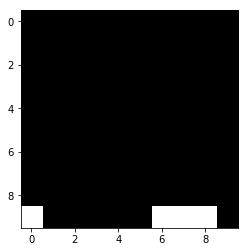

In [5]:
c = 0
for e in range(10):
    loss = 0.
    env.reset()
    game_over = False
    # get initial input
    input_t = env.observe()

    plt.imshow(input_t.reshape((grid_size,)*2),
               interpolation='none', cmap='gray')
    plt.savefig("%03d.png" % c)
    c += 1
    while not game_over:
        input_tm1 = input_t

        # get next action
        q = model.predict(input_tm1)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        input_t, reward, game_over = env.act(action)

        plt.imshow(input_t.reshape((grid_size,)*2),
                   interpolation='none', cmap='gray')
        plt.savefig("%03d.png" % c)
        c += 1